
# Cepheids

Cepheids are a type of variable star that pulsate radially, varying in both diameter and temperature, which produces changes in brightness with a well-defined stable period and amplitude. These stars are significant in the field of astronomy for several reasons:

1. **Standard Candles**: Cepheids have a well-established relationship between their luminosity and pulsation period, known as the Leavitt law or period-luminosity relation. This makes them excellent standard candles for measuring astronomical distances.

2. **Distance Measurement**: By observing the period of a Cepheid's brightness variations, astronomers can determine its absolute magnitude. Comparing this with the apparent magnitude allows for the calculation of the distance to the star, which is crucial for mapping the scale of the universe.

3. **Galactic and Extragalactic Studies**: Cepheids are used to measure distances within our galaxy and to nearby galaxies. This helps in understanding the structure and scale of the Milky Way and the local group of galaxies.

4. **Historical Importance**: The discovery of Cepheids in the Andromeda galaxy by Edwin Hubble was pivotal in establishing that the universe is expanding, leading to the formulation of the Big Bang theory.

Cepheids continue to be a vital tool in modern astrophysics, aiding in the calibration of other distance measurement methods and contributing to our understanding of the cosmos.

# Part 1

The data in ```cepheids.csv``` is organised in two columns: the period of the cepheid variable and its absolute magnitude calculated from mean luminosity.

These two values are actually related by the Leavitt law:
$$M = a \cdot \log_{10}{P} + b$$

First, we find the constants $a$ and $b$ in this relation to fit the given data.

In [ ]:
# The Leavitt law is a linear relationship between the absolute magnitude and the log of the pulsation period
# This problem can be modelled as a linear regressor
# Using sklearn linear models

#important libraries
import pandas as pd
import numpy as np
from sklearn import linear_model

cepheid_data = pd.read_csv("cepheids.csv") #read the dataset
cepheid_data['log_p'] = np.log10(cepheid_data['Period']) #appending a column of log10(Period)

regressor = linear_model.LinearRegression() #instantiating the regression object
regressor.fit(pd.DataFrame(cepheid_data['log_p']), cepheid_data['M'])#fitting it on the data
a = regressor.coef_[0]
b = regressor.intercept_
print(f"a: {a}, b = {b}") #printing the constants

a: -2.2164100598180405, b = -1.6808674146142555


Next, we plot the data along with our fitted line to visually verify that we have found the correct constants.

Text(0, 0.5, 'M')

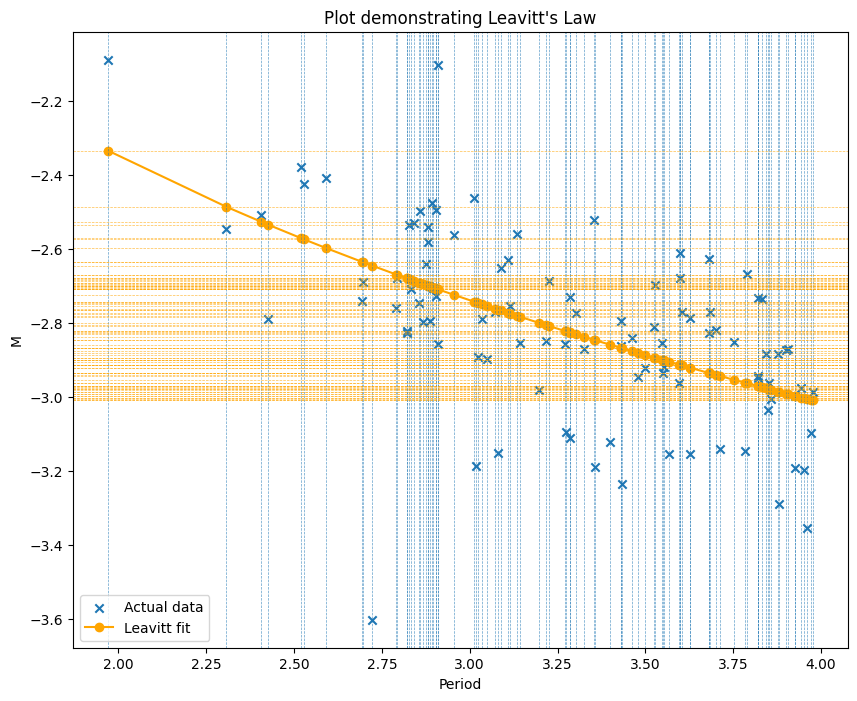

In [ ]:
fitted_m = regressor.predict(pd.DataFrame(cepheid_data['log_p'])) #fitted M
plot_df = cepheid_data #initializing a new df for plotting purpose
plot_df['fitted_m'] = fitted_m #adding the fitted M column
plot_df.sort_values(by='Period', inplace=True) #sorting the dataframe along period for plotting

#Plotting the original M data and the fitted M values against the Period
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8)) #figure size
plt.scatter((plot_df['Period']), plot_df['M'], marker = 'x', label = 'Actual data') #line plot of actual period
plt.plot((plot_df['Period']), plot_df['fitted_m'], marker = 'o', label = 'Leavitt fit', color = 'orange') #line plot of predicted period

for x_val in (cepheid_data['Period']): # Adding vertical grid lines for each x value
    plt.axvline(x=x_val, linestyle='--', linewidth=0.5, alpha=0.7)

for y_val in cepheid_data['fitted_m']: # Adding horizontal grid lines for each y value
    plt.axhline(y=y_val, linestyle='--', linewidth=0.5, alpha=0.7, color = 'orange')

plt.legend()
plt.title("Plot demonstrating Leavitt's Law") #plot title
plt.xlabel('Period') #plot x axis label
plt.ylabel('M') #plot y axs label

# Part 2

Now we are ready to use the result we have obtained from the above markdown to solve the problem.

Given in the ```curves.csv``` file is the data of the light curves of many cepheids in the line of sight of a galaxy. The data contains three columns: ID(Unique for every cepheid), JD (the julian date of observation) and the apparent magnitude observed.

First we need to find the period of each cepheid.

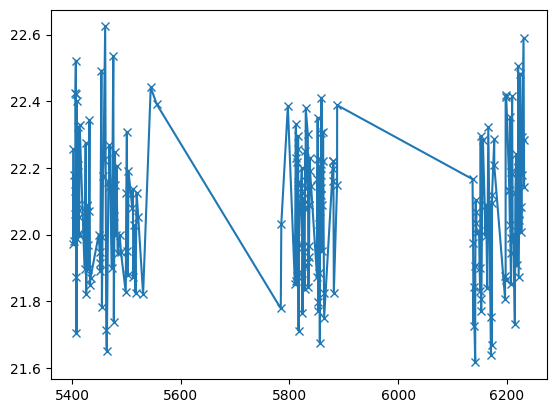

In [ ]:
# Looking at the data, we find that for the same cepheid, multiple different values of m are seen at different observation times
curves_data = pd.read_csv("curves.csv") #reading the curves dataset

ceph_2434670 = curves_data[curves_data['ID'] == 2434670] #visualizing the apparent magnitude for cepheid 2434670
plt.plot(ceph_2434670['JD'], ceph_2434670['m'], marker = 'x')

In [ ]:
# We see almost an year of a gap between the clusters of readings, which is not surprising owing to the earth's rotation
# Also the data acquisition is done at non-uniformly spaced intervals - so an FFT can't give the correct period
# Using the Lomb-Scarge Periodogram to approximate the frequency spectrum
from astropy.io import fits
from astropy.timeseries import LombScargle, BoxLeastSquares

period_array = [] #will store the period and the mean apparent magnitude for each cepheid
for cepheid in curves_data['ID'].unique():
    cepheid_data = curves_data[curves_data['ID'] == cepheid] #data for one cepheid

    frequency, power = LombScargle(cepheid_data['JD'], cepheid_data['m']).autopower() #getting the power spectrum
    mean_apparent_magnitude = np.mean(cepheid_data['m'])
    period_array.append([cepheid, 1/frequency[np.argmax(power)], mean_apparent_magnitude]) #append the period and the mean apparent magnitude along with the cepheid ID

period_array = pd.DataFrame(period_array, columns = ['Cepheid_ID', 'Period', 'Mean_app_mag']) #converting to a numpy array for ease of computation

Next, using the calculated periods, we find the absolute magnitude of these stars using the relation we found earlier.



In [ ]:
period_array['absolute_mag'] = a*np.log10(period_array['Period']) + b #applying the curve fit coefficients to the period array above

Then, using the apparent magnitude data, we find the distance to these cepheid variables.

In [ ]:
# d = 10^{(apparent_M - absolute_M + 5)/5}
period_array['distance'] = np.power(10, 1 + (period_array['Mean_app_mag'] - period_array['absolute_mag'])/5)

Finally, we find the distance to the galaxy being observed.



The estimated distance of the galaxy is 0.8336621087841032 Mpc




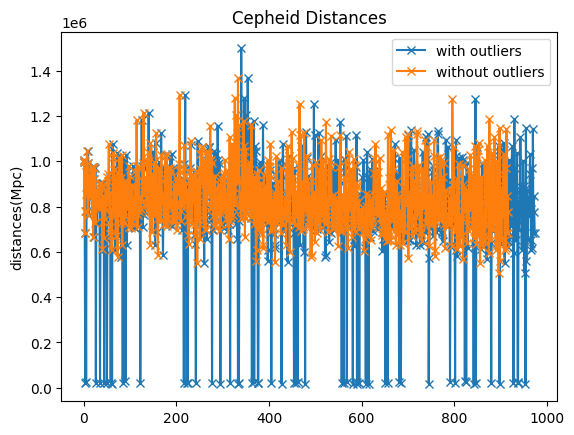

In [ ]:
#Instead of just averaging, I will remove outliers(If any) before averaging
# Outlier removal using the inter quartile range
q_h = period_array['distance'].quantile(0.85)
q_l = period_array['distance'].quantile(0.15)

thres_low = q_l - 1.5*(q_h - q_l)
thres_high = q_h + 1.5*(q_h - q_l)

distances = []
for i in range(len(period_array['distance'])):
    if((period_array['distance'][i] > thres_low) and (period_array['distance'][i] < thres_high)):
        distances.append(period_array['distance'][i])

#visualizing the outlier removal
plt.plot(np.arange(len(period_array['distance'])), period_array['distance'], marker = 'x', label = 'with outliers')
plt.plot(np.arange(len(distances)), distances, marker = 'x', label = 'without outliers')

plt.ylabel('distances(Mpc)')
plt.title('Cepheid Distances')
plt.legend()

#Final distance from the galaxy
print(f"\n\nThe estimated distance of the galaxy is {np.mean(distances)/10**6} Mpc\n\n")

# Part 3

A qualitative explanation of the thermal instability that leads to the pulsations in Cepheid variable stars, focusing on the role of the κ-mechanism (opacity mechanism).

The luminosity variation in these stars can be attributed to a variation in the opacity of the star surface, i.e, its ability to allow photons to reach out of the star. The opacilty arises from multiple processes, and the source of opacity determines its temperature variation. In a normal star the opacity is caused by factors that make it reduce with an increase in temperature. So if a normal star like the sun compresses (and hence heats up), the opacity reduces, letting out radiation in a non-adiabatic manner leading to a reduction in the temperature, which stabilizes the star back to its original size and opacity, and hence the luminosity. But the opacity in a cepheid star is caused by the ionization of He to He+ and He+ to He++, the latter existing at high temperatures and also being more opaque. So with a compression, temperature increases, increasing the production of He++ and hence increasing the opacity, trapping more radiation, regeneratively increasing He++ and hence further increasing energy trapping. The star then expands back only due to the intense radiation pressure buildup, with a gradual temperature reduction (T reduces due to expansion) with outward radiation flow, decreasing opacity further, and hence reducing the temperature even more. The insufficient internal radiation pressure because of the increased radiation now can't hold up against the crushing gravity of the star, bringing it back to compression. This is the best available explanation for the periodicity of the process.